In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import json
import math

import joblib
gbdt_model = joblib.load("/storage/gpfs_data/icarus/local/users/sommaggio/simul_z/PID/gbdt_model.pkl")

file = uproot.open("/storage/gpfs_data/icarus/local/users/sommaggio/simul_z/PID/selection_new_PID/data_struct_mc2d.root")
#tree = file['tree']
#print(tree.keys())
#bad = {
#    "slice/TObject",
#    "slice/TObject/fUniqueID",
#    "slice/TObject/fBits",
#}
#branches = [name for name in tree.keys() if name not in bad]
#slices = tree.arrays(branches,library='ak') 
#for the approach above the TObject branch should not be present
slices = file['tree'].arrays(library='ak')
print(slices)
print(slices.fields)
print(json.dumps(ak.to_list(slices[0]), indent=2))


[{fUniqueID: 0, fBits: 33554432, slice_number: 0, run: 9729, ...}, ..., {...}]
['fUniqueID', 'fBits', 'slice_number', 'run', 'subrun', 'evt', 'is_clear_cosmic', 'true_neutrino_energy', 'isinFV', 'reco_true_vertex_distance', 'all_tracks_contained', 'light_charge_baricenter', 'reco_vertex', 'true_vertex', 'truth_matching_efficiency', 'truth_matching_purity', 'tracks.fUniqueID', 'tracks.fBits', 'tracks.reco.fUniqueID', 'tracks.reco.fBits', 'tracks.reco.dedx', 'tracks.reco.rr', 'tracks.reco.pitch', 'tracks.reco.hitx', 'tracks.reco.hity', 'tracks.reco.hitz', 'tracks.reco.length', 'tracks.reco.trackscore', 'tracks.reco.start_distance_from_reco_vertex', 'tracks.reco.end_distance_from_reco_vertex', 'tracks.reco.is_start_contained', 'tracks.reco.is_end_contained', 'tracks.reco.all_in_1_tpc', 'tracks.reco.is_primary', 'tracks.reco.energy_deposited_as_pro', 'tracks.reco.energy_deposited_as_pi', 'tracks.reco.start', 'tracks.reco.end', 'tracks.reco.likelihood_ratios', 'tracks.reco.deposited_energy'

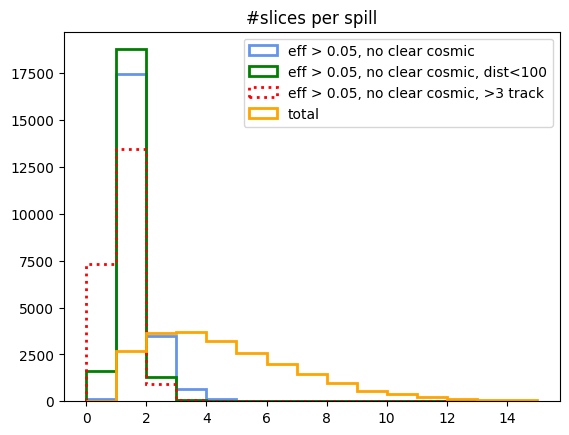

In [12]:

run = slices['run'][0] 
evt = slices['evt'][0]
subrun = slices['subrun'][0]
tot_slices = 0
tot_slices_cuts = 0 
tot_slices_cuts_plus_dist = 0
tot_slices_cuts_plus_ntracks = 0
tot_slices_list = []
tot_slices_cuts_list = []
tot_slices_cuts_plus_dist_list = []
tot_slices_cuts_plus_ntracks_list = []

#print(run,evt,subrun)

for slice in slices:
    #print('nuova slice')
    #print(slice['run'], slice['evt'], slice['subrun'])
    #print(slice['is_clear_cosmic'], slice['truth_matching_efficiency'], len(slice['tracks.reco.ipfp']), slice['reco_true_vertex_distance'])
    if slice['run']==run and slice['evt']==evt and slice['subrun']==subrun:
        tot_slices = tot_slices + 1
        if slice['is_clear_cosmic']==False and slice['truth_matching_efficiency'] > 0.05 : 
            tot_slices_cuts = tot_slices_cuts +1
            if len(slice['tracks.reco.ipfp'])>3:
                tot_slices_cuts_plus_ntracks = tot_slices_cuts_plus_ntracks +1
            if slice['reco_true_vertex_distance'] < 100:
                tot_slices_cuts_plus_dist = tot_slices_cuts_plus_dist +1
    else : 
        run = slice['run'] 
        evt = slice['evt']
        subrun = slice['subrun']
        tot_slices_list.append(tot_slices)
        tot_slices_cuts_list.append(tot_slices_cuts)
        tot_slices_cuts_plus_dist_list.append(tot_slices_cuts_plus_dist)
        tot_slices_cuts_plus_ntracks_list.append(tot_slices_cuts_plus_ntracks)
        tot_slices=1
        if slice['is_clear_cosmic']==False and slice['truth_matching_efficiency'] > 0.05 :
            tot_slices_cuts=1
            if len(slice['tracks.reco.ipfp'])>3:
                tot_slices_cuts_plus_ntracks = 1
            if slice['reco_true_vertex_distance'] < 100:
                tot_slices_cuts_plus_dist = 1
        else : 
            tot_slices_cuts=0
            tot_slices_cuts_plus_ntracks = 0
            tot_slices_cuts_plus_dist = 0
    #print(tot_slices, tot_slices_cuts, tot_slices_cuts_plus_ntracks, tot_slices_cuts_plus_dist)

plt.hist(tot_slices_cuts_list, bins=15, range=(0,15), label = 'eff > 0.05, no clear cosmic' , histtype='step', color='cornflowerblue', lw=2, density=False)
plt.hist(tot_slices_cuts_plus_dist_list, bins=15, range=(0,15), label = 'eff > 0.05, no clear cosmic, dist<100' , histtype='step', color='green', lw=2, density=False)
plt.hist(tot_slices_cuts_plus_ntracks_list, bins=15, range=(0,15), label = 'eff > 0.05, no clear cosmic, >3 track' , histtype='step', ls='dotted', color='red', lw=2, density=False)
plt.hist(tot_slices_list, bins=15, range=(0,15), label = 'total' , histtype='step', color='orange', lw=2, density=False)
plt.title('#slices per spill')
plt.legend()


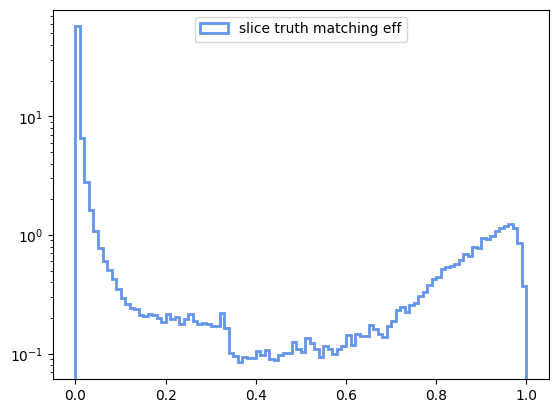

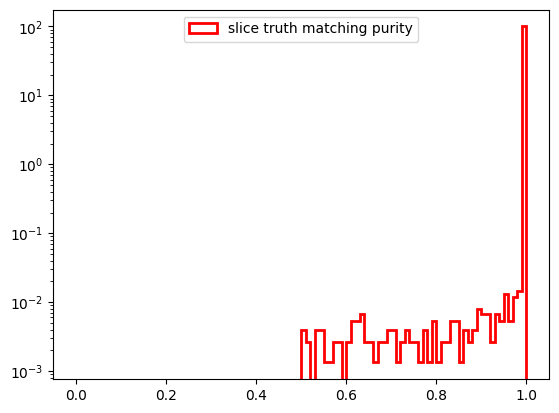

In [33]:
plt.yscale('log')
plt.hist(slices['truth_matching_efficiency'], bins=100, range=(0,1), label='slice truth matching eff', histtype='step',lw=2,color='cornflowerblue', density=True)
plt.legend(loc='upper center')
plt.show()
plt.yscale('log')
plt.hist(slices['truth_matching_purity'], bins=100, range=(0,1), label='slice truth matching purity', histtype='step', color='red', lw=2, density=True)
plt.legend(loc='upper center')
plt.show()


In [3]:
def find_muon(slice):
    if slice['is_clear_cosmic']== True : return -1
    max_length=-1
    muon_index=-1
    for i,_ in enumerate(slice['tracks.reco.length']): #cicle over the tracks in the slice
        if math.isnan(slice['tracks.reco.length'][i]) and math.isnan(slice['tracks.reco.start'][i][0]) : continue
        if slice['tracks.reco.trackscore'][i]< 0.5 : continue
        if slice['tracks.reco.start_distance_from_reco_vertex'][i] >= 10 : continue 
        if slice['tracks.reco.length'][i] <= 50 : continue
        if abs(slice['tracks.truth.pdg'][i])!=13 : continue
        if slice['tracks.reco.length'][i] < max_length : continue
        else : max_length = slice['tracks.reco.length'][i]
        if slice['tracks.reco.all_in_1_tpc'][i] == False : continue
        if slice['tracks.reco.is_primary'][i] == False : continue
        if slice['tracks.reco.is_start_contained'][i] == False : continue
        if slice['tracks.reco.is_end_contained'][i] == False : continue
        muon_index = i

    return muon_index

import awkward as ak

def find_muon_full_vectorized(slices):
    lengths = slices['tracks.reco.length']

    mask = (
        (~slices['is_clear_cosmic']) &
        (slices['tracks.reco.trackscore'] >= 0.5) &
        (slices['tracks.reco.start_distance_from_reco_vertex'] < 10) &
        (lengths > 50) &
        (abs(slices['tracks.truth.pdg']) == 13) &
        (slices['tracks.reco.all_in_1_tpc']) &
        (slices['tracks.reco.is_primary']) &
        (slices['tracks.reco.is_start_contained']) &
        (slices['tracks.reco.is_end_contained'])
    )

    valid = ak.any(mask, axis=1)

    muon_idx = ak.argmax(ak.where(mask, lengths, -1), axis=1)

    muon_idx = ak.where(valid, muon_idx, -1)
    muon_idx = ak.mask(muon_idx, muon_idx != -1)
    return muon_idx



In [ ]:
def find_proton(slice):
    proton_index = -1
    for i,_ in enumerate(slice['tracks.reco.length']):
        #common between protons and pions
        if math.isnan(slice['tracks.reco.length'][i]) and math.isnan(slice['tracks.reco.start'][i][0]) : continue
        if slice['tracks.reco.is_end_contained'][i] == False : continue
        if slice['tracks.reco.is_primary'][i] == False : continue
        if min(slice['tracks.reco.end_distance_from_reco_vertex'][i],slice['tracks.reco.start_distance_from_reco_vertex'][i]) > 50 : continue
        #speficic for protons
        if abs(slice['tracks.truth.pdg'][i]) != 2212 : continue 
        if slice['tracks.reco.trackscore'][i] < 0.3 : continue
        if math.isnan(slice['tracks.reco.start'][i][0]) or math.isnan(slice['tracks.reco.start'][i][1]) or math.isnan(slice['tracks.reco.start'][i][2]) : continue
        if math.isnan(slice['tracks.reco.end'][i][0]) or math.isnan(slice['tracks.reco.end'][i][1]) or math.isnan(slice['tracks.reco.end'][i][2]) : continue
        if slice['tracks.reco.start_distance_from_reco_vertex'][i] >= 10 : continue
        if slice['tracks.reco.energy_deposited_as_pro'][i] < 50 : continue
        proton_index = i
    return proton_index

def find_all_protons_full_vectorized(slices):
    valid_start = ~np.isnan(slices['tracks.reco.start'][...,0]) & \
                  ~np.isnan(slices['tracks.reco.start'][...,1]) & \
                  ~np.isnan(slices['tracks.reco.start'][...,2])

    valid_end = ~np.isnan(slices['tracks.reco.end'][...,0]) & \
                ~np.isnan(slices['tracks.reco.end'][...,1]) & \
                ~np.isnan(slices['tracks.reco.end'][...,2])

    mask = (
        (slices['tracks.reco.length'] >= 0) &
        (slices['tracks.reco.is_end_contained']) &
        (slices['tracks.reco.is_primary']) &
        (np.minimum(
            slices['tracks.reco.end_distance_from_reco_vertex'],
            slices['tracks.reco.start_distance_from_reco_vertex']
        ) <= 50) &
        (abs(slices['tracks.truth.pdg']) == 2212) &
        (slices['tracks.reco.trackscore'] >= 0.3) &
        (slices['tracks.reco.start_distance_from_reco_vertex'] < 10) &
        (slices['tracks.reco.energy_deposited_as_pro'] >= 50) &
        valid_start &
        valid_end
    )

    # Indici di tutte le tracce protoniche per slice
    proton_indices = ak.local_index(mask)[mask]

    return proton_indices


def find_pion(slice):
    proton_index = -1
    for i,_ in enumerate(slice['tracks.reco.length']):
        #common between protons and pions
        if math.isnan(slice['tracks.reco.length'][i]) and math.isnan(slice['tracks.reco.start'][i][0]) : continue
        if slice['tracks.reco.is_end_contained'][i] == False : continue
        if slice['tracks.reco.is_primary'][i] == False : continue
        if min(slice['tracks.reco.end_distance_from_reco_vertex'][i],slice['tracks.reco.start_distance_from_reco_vertex'][i]) > 50 : continue
        #speficic for pion
        if abs(slice['tracks.truth.pdg'][i]) != 211 : continue 
        if slice['tracks.reco.trackscore'][i] < 0.5 : continue
        if math.isnan(slice['tracks.reco.start'][i][0]) or math.isnan(slice['tracks.reco.start'][i][1]) or math.isnan(slice['tracks.reco.start'][i][2]) : continue
        if math.isnan(slice['tracks.reco.end'][i][0]) or math.isnan(slice['tracks.reco.end'][i][1]) or math.isnan(slice['tracks.reco.end'][i][2]) : continue
        if slice['tracks.reco.start_distance_from_reco_vertex'][i]>= 10 : continue
        if slice['tracks.reco.energy_deposited_as_pro'][i] < 25 : continue
        proton_index = i
    return proton_index

def find_all_pions_full_vectorized(slices):
    valid_start = ~np.isnan(slices['tracks.reco.start'][...,0]) & \
                  ~np.isnan(slices['tracks.reco.start'][...,1]) & \
                  ~np.isnan(slices['tracks.reco.start'][...,2])

    valid_end = ~np.isnan(slices['tracks.reco.end'][...,0]) & \
                ~np.isnan(slices['tracks.reco.end'][...,1]) & \
                ~np.isnan(slices['tracks.reco.end'][...,2])

    mask = (
        (slices['tracks.reco.length'] >= 0) &
        (slices['tracks.reco.is_end_contained']) &
        (slices['tracks.reco.is_primary']) &
        (np.minimum(
            slices['tracks.reco.end_distance_from_reco_vertex'],
            slices['tracks.reco.start_distance_from_reco_vertex']
        ) <= 50) &
        (abs(slices['tracks.truth.pdg']) == 211) &
        (slices['tracks.reco.trackscore'] >= 0.5) &
        (slices['tracks.reco.start_distance_from_reco_vertex'] < 10) &
        (slices['tracks.reco.energy_deposited_as_pi'] >= 25) &
        valid_start &
        valid_end
    )

    # Indici di tutte le tracce protoniche per slice
    pions_indices = ak.local_index(mask)[mask]

    return pions_indices


In [ ]:
def true_class_slice(slices)
    #todo

In [95]:
muon_counts = 0
for slice in slices:
    muon_idx = find_muon(slice)
    #print(muon_idx)
    if muon_idx!=-1 : muon_counts = muon_counts + 1
print(muon_counts,'muon tracks')

5325 muon tracks


In [150]:
muon_idx = find_muon_full_vectorized(slices)
print(ak.to_list(muon_idx))
print(ak.sum(ak.where(muon_idx!=-1,1,0)))

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 2, None, None, None, None, None, None, None, None, None, None, None, None, None, 3, None, None, None, 4, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 2, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 3, None, None, None, None, None, None, None, None, None, None, None, 3, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 3, None, None, 2, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 2, None, None, None, 4, None, 

In [73]:
proton_counts = 0 
for slice in slices:
    if find_proton(slice)!=-1 : proton_counts = proton_counts + 1
print(proton_counts,'proton tracks')

10691 proton tracks


In [110]:
proton_indices = find_all_protons_full_vectorized(slices)
print(proton_indices)
print(ak.count(proton_indices))

[[], [], [], [], [], [], [], [], [], ..., [], [1], [], [], [], [], [1], [], []]
13513


In [74]:
pion_counts = 0 
for slice in slices:
    if find_pion(slice)!=-1 : pion_counts = pion_counts + 1
print(pion_counts,'pion tracks')

1805 pion tracks


In [114]:
pion_indices = find_all_pions_full_vectorized(slices)
print(pion_indices)
print(ak.count(pion_indices))

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]
1890


In [ ]:
import random as rnd
def get_random_color():
    random_int = rnd.randint(0,0xFFFFFF)
    return '#{:06x}'.format(random_int)


#print(json.dumps(ak.to_list(slices['tracks.reco.likelihood_ratios'][0]), indent=2))
#print(json.dumps(ak.to_list(slices['tracks.truth.true_class'][0]),indent=2))

#cols=['black','green','blue','cyan','red','pink']
#for i in range(6):
    #ilr=[]
    #for slice in slices:
    #    likelihood_ratio = [lr[0] for lr,cls in zip(slice['tracks.reco.likelihood_ratios'],slice['tracks.truth.true_class']) if cls==i and (find_muon(slice)!=-1 or cls>1)]
    #    ilr.extend(likelihood_ratio)
    
    #plt.hist(np.array(ilr), bins=100, range=(-1,1), color=cols[i], label='class{}'.format(i), histtype='stepfilled',lw=0, density=True, alpha=0.5)
    #plt.hist(np.array(ilr), bins=100, range=(-1,1), color=cols[i], histtype='step',lw=2, density=True)
#plt.legend(loc='upper center')


muon_indeces = find_muon_full_vectorized(slices)
proton_indeces = find_all_protons_full_vectorized(slices)
pion_indeces = find_all_pions_full_vectorized(slices)
lr_mu_class0=[]
lr_mu_class1=[]
for i,slice in enumerate(slices):
    if muon_indeces[i]!=None : 
        if slice['tracks.truth.true_class'][muon_indeces[i]] == 0:
            lr_mu_class0.append(slice['tracks.reco.likelihood_ratios'][muon_indeces[i]][0])
        if slice['tracks.truth.true_class'][muon_indeces[i]] == 1 : 
            lr_mu_class1.append(slice['tracks.reco.likelihood_ratios'][muon_indeces[i]][0])
    #if len(proton_indices[i])!=0 :
    #    if slice['tracks.truth.true_class'][proton_indeces[i]] == 2:




In [3]:
def find_candidate_muon_full_vectorized(slices):
    lengths = slices['tracks.reco.length']

    mask = (
        (~slices['is_clear_cosmic']) &
        (slices['tracks.reco.trackscore'] >= 0.5) &
        (slices['tracks.reco.start_distance_from_reco_vertex'] < 10) &
        (lengths > 50) &
        (slices['tracks.reco.all_in_1_tpc']) &
        (slices['tracks.reco.is_primary']) &
        (slices['tracks.reco.is_start_contained']) &
        (slices['tracks.reco.is_end_contained'])
    )

    valid = ak.any(mask, axis=1)

    muon_idx = ak.argmax(ak.where(mask, lengths, -1), axis=1)

    muon_idx = ak.where(valid, muon_idx, -1)
    muon_idx = ak.mask(muon_idx, muon_idx != -1)
    return muon_idx


def find_pfp_full_vectorized(slices):
    valid_start = ~np.isnan(slices['tracks.reco.start'][...,0]) & \
                  ~np.isnan(slices['tracks.reco.start'][...,1]) & \
                  ~np.isnan(slices['tracks.reco.start'][...,2])

    valid_end = ~np.isnan(slices['tracks.reco.end'][...,0]) & \
                ~np.isnan(slices['tracks.reco.end'][...,1]) & \
                ~np.isnan(slices['tracks.reco.end'][...,2])

    mask = (
        (slices['tracks.reco.length'] >= 0) &
        (slices['tracks.reco.is_end_contained']) &
        (slices['tracks.reco.is_primary']) &
        (np.minimum(
            slices['tracks.reco.end_distance_from_reco_vertex'],
            slices['tracks.reco.start_distance_from_reco_vertex']
        ) <= 50) &
        (slices['tracks.reco.trackscore'] >= 0.3) &
        (slices['tracks.reco.start_distance_from_reco_vertex'] < 10) &
        valid_start &
        valid_end
    )

    # Indici di tutte le tracce protoniche per slice
    pfp_indices = ak.local_index(mask)[mask]

    return pfp_indices

In [4]:
def classify_slice(slice, i, muon_candidates, pfps) :
    if slice['is_clear_cosmic']==True or slice['truth_matching_efficiency'] <= 0.05 or slice['reco_true_vertex_distance'] >= 100 : return 'bad_slice'
    class_string = ''
    #load indicises of candidate muons, protons and pions based on the preselection
    muon_idx = muon_candidates[i] 
    pfps_idxs = pfps[i]
    if(muon_idx==None and len(pfps_idxs)==0) : return 'unclassified'
    else:
        #is the muon candidate a muon ?
        if(muon_idx==None) : class_string = class_string + '00'
        else : 
            features = ak.to_list(slice['tracks.reco.likelihood_ratios'][muon_idx]) + [ slice['tracks.reco.deposited_energy'][muon_idx] ] 
            if gbdt_model.predict([features])==0 : class_string = class_string + '10'
            elif gbdt_model.predict([features])==1 : class_string = class_string + '01'
            else: 
                class_string = class_string + '00'
                muon_idx = None
        #check for protons and pions 
        if len(pfps_idxs)==0 : class_string = class_string + '00'
        else :
            n_proton_rising = 0
            n_proton_interacting = 0
            n_pion_rising = 0
            n_pion_interacting = 0
            for p in pfps_idxs:
                if p == muon_idx : continue
                features = ak.to_list(slice['tracks.reco.likelihood_ratios'][p]) + [ slice['tracks.reco.deposited_energy'][p] ]
                if gbdt_model.predict([features]) == 2 and slice['tracks.reco.energy_deposited_as_pro'][p]>=50 : n_proton_rising = n_proton_rising + 1
                if gbdt_model.predict([features]) == 3 and slice['tracks.reco.energy_deposited_as_pro'][p]>=50 : n_proton_interacting = n_proton_interacting +1
                if gbdt_model.predict([features]) == 4 and slice['tracks.reco.energy_deposited_as_pi'][p]>=25 and slice['tracks.reco.trackscore'][p]>=0.5 : n_pion_rising = n_pion_rising +1
                if gbdt_model.predict([features]) == 5 and slice['tracks.reco.energy_deposited_as_pi'][p]>=25 and slice['tracks.reco.trackscore'][p]>=0.5 : n_pion_interacting = n_pion_interacting +1
            
            class_string = class_string + '{}{}{}{}'.format(n_proton_rising,n_proton_interacting,n_pion_rising,n_pion_interacting)
    return class_string    


In [5]:

reco_class = []

muon_candidates = find_candidate_muon_full_vectorized(slices)
pfps = find_pfp_full_vectorized(slices)

for i, slice in enumerate(slices):
    reco_class.append(classify_slice(slice, i, muon_candidates, pfps))
   
print(reco_class)


['bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', '001210', 'bad_slice', 'bad_slice', 'bad_slice', '010001', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', '001001', 'bad_slice', 'bad_slice', 'bad_slice', '011000', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', '002000', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', '000100', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', '000200', 'bad_slice', 'bad_slice', 'bad_slice', '001100', 'bad_slice', 'bad_slice', 'bad_slice', '000100', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', '000000', 'bad_slice', 'bad_slice', 'bad_slice', '002002', 'bad_slice', 'bad_slice', 'bad_slice', 'bad_slice', '100000', 'bad_sli

In [10]:
tot_numuCC = sum(1 for x in reco_class if x.startswith('01') or x.startswith('10'))
print(tot_numuCC)

3954
